# Calculating the power density spectrum

## In one-dimension
We first start with a common analysis of turbulent fields, especially those that are perdioic and easily represented using Fourier modes: the power density spectrum.

We begin with an 1D real field $\psi(x)\in\mathbb{R}$ in a domain of $x\in [0,L]$. We can obtain its Fourier coefficient $\hat \psi(k)$ using FFT. Then we have the Parseval's theorem
\begin{align}
    \sum_{k} |\hat \psi(k)|^2 = \frac{1}{L}\int^{L}_0 |\psi(x,y)|^2 \mathrm{d}x.
\end{align}
Note that the right-hand-side is the spatial average of $|\psi(x,y)|^2$. This is why we use the name "density" in "power density spectrum".

We test this in Dedalus

In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

from numpy.random import normal

plt.style.use('../subroutine/ryan_mplstyle.mplstyle')

In [2]:
L = 10
N = 50
dtype = np.float64
dealias = 3/2

# Bases
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.RealFourier(xcoord, size=N, bounds=(0, L), dealias=dealias)
x = dist.local_grid(xbasis)
k_int = dist.local_modes(xbasis) # This is just an index of the wavenumber, alwayd integers
k = xbasis.wavenumbers[dist.local_modes(xbasis)] # this is the value of the actual wavenumber, scaled by domain size

# Fields
psi = dist.Field(bases=xbasis)

In [3]:
# Initialize the psi field with random Fourier coefficient
psi['g'] = 0
psi.fill_random('g', distribution='normal', scale=1); psi.low_pass_filter(shape=20)
# psi['g'] -= np.mean(psi['g'])

In [4]:
# This is the Fourier coefficient squared
psi_mag = psi['c']*np.conj(psi['c'])

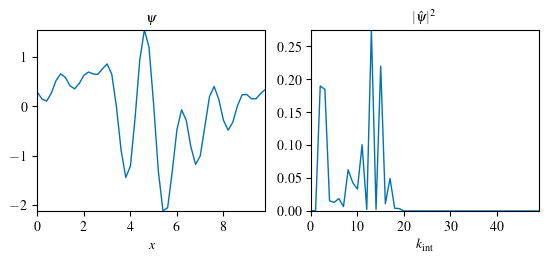

In [5]:
fig=plt.figure(figsize=(11/1.7, 4/1.7))
plt.subplot(1, 2, 1)
plt.plot(x,psi['g'])
plt.title(r"$\psi$")
plt.xlabel("$x$")

plt.subplot(1, 2, 2)
plt.plot(k_int,psi_mag)
plt.title(r'$|\hat{\psi}|^2$')
plt.xlabel(r"$k_\mathrm{int}$")

plt.show()

In [6]:
# This is the sum of Fourier coefficient squared
print(np.sum(psi_mag))
# This is integral of the field squared in real space
print(d3.Integrate(np.abs(psi)**2,('x')).evaluate()['g'].ravel()/L)

1.2372152158935958
[0.61901095]


Wait a minute. They are not equal?! 

This is because for a real field, it is usual to use the conjugate symmetry of the Fourier coefficient for real field to disgard (almost) half of the Fourier coefficient. Sometimes this is done by saving only the positive half of the *complex* Fourier coefficient. In Dedalus, instead, the coefficients are *real*, effectively being factors in front of the $\sin$ and $\cos$ basis. Then this is also only half the storage requirement compared to saving all the *complex* coefficient.

Then each FFT implementation have different conventions in scaling the coefficients. One has to be careful when using any FFT algorithm to pay attention and check. The test is of course the Parseval's theorem. 

For Dedalus 1D real field, one should scale $|\hat\psi(k)|^2$ by $1/2$ for all non-zero wavenumbers. The zero wavenumber should have a factor of one.

In [7]:
factor = np.ones(psi_mag.shape)*1/2
factor[0] = 1

In [8]:
print(np.sum(psi_mag*factor))
print(d3.Integrate(np.abs(psi)**2,('x')).evaluate()['g'].ravel()[0]/L)

0.6190109468864704
0.6190109468864704


Now they match :) (up to numerical error).

We are insterested in the power density spectrum. It is a function of each unique wavenumber. Since Dedalus uses $\sin$ and $\cos$ basis, each unique value is represented twive, once for $\sin(k)$ and once for $\cos(k)$. This is also clear from a print out of the actual wavenumber below. 

In [9]:
print(k[:10])

[0.         0.         0.62831853 0.62831853 1.25663706 1.25663706
 1.88495559 1.88495559 2.51327412 2.51327412]


For the power density spectrum, we sum up the two coefficients squared with the same wavenumber. This produce an object half the size of the resolution prescribed. We define the function `isospectrum_1d`

In [10]:
def isospectrum_1d(psi_mag):
    N = psi_mag.size
    psi_spec = (psi_mag[0::2]+psi_mag[1::2])/2
    psi_spec[0] += psi_mag[0]/2

    return psi_spec

In [11]:
psi_spec = isospectrum_1d(psi_mag)

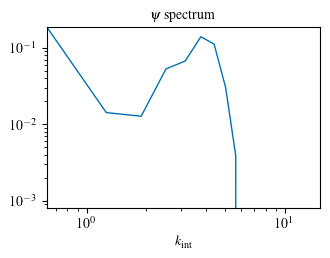

In [12]:
fig=plt.figure(figsize=(6/1.7, 4/1.7))

plt.loglog(k[0::2],psi_spec)
plt.title(r'$\psi$ spectrum')
plt.xlabel(r"$k_\mathrm{int}$")

plt.show()

The final test of our algorithm is whether is still preserved the variance of the original data (satisfied Parseval's). 

Any code calculating the spetrum should pass this test. It is surprising how many spectrum function in commonly used psudospectral code for GFD get this wrong. You should always check when using others' function or after you wrote your own.

In [13]:
print(np.sum(psi_spec))
print(d3.Integrate(np.abs(psi)**2,('x')).evaluate()['g'].ravel()[0]/L)

0.6190109468864703
0.6190109468864704


Power density spectrum is popular in the study of turbulence is deeply rooted in the mathematics of Gaussian random fields. It is related to the two-point corrolation function (or autocorrelation function) of the data, by using the Wiener–Khinchin theorem. We recomment the book of {cite}`Yaglom_62` for a through treatment, far beyond what we covered here.

## In two-dimensions

Assume we have a 2D doubly-perdioic field $\psi(x,y)\in\mathbb{R}$ and its Fourier coefficient $\hat \psi(k,\ell)$. The Parseval's theorem now states
\begin{align}
    \sum_{k,\ell} |\hat \psi(k,\ell)|^2 = \frac{1}{Lx*Ly}\int^{L_y}_0\int^{L_x}_0 |\psi(x,y)|^2 \mathrm{d}x\mathrm{d}y
\end{align}
We test this in Dedalus using an example that has $Lx\neq Ly$ and differing resolution each side.

In [96]:
Lx, Ly = 12*np.pi, 10*np.pi
Nx, Ny = 60, 40
dtype = np.float64
dealias = 3/2

# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)

x, y = dist.local_grids(xbasis, ybasis)
x = x.ravel(); y = y.ravel()
x_mat, y_mat = np.meshgrid(x, y); x_mat = x_mat.T; y_mat = y_mat.T

k_int = dist.local_modes(xbasis).ravel(); l_int = dist.local_modes(ybasis).ravel() # This is just an index of the wavenumber, alwayd integers
k = xbasis.wavenumbers[dist.local_modes(xbasis)]; l = ybasis.wavenumbers[dist.local_modes(ybasis)]; # this is the value of the actual wavenumber, scaled by domain size

# Fields
psi = dist.Field(bases=(xbasis,ybasis) )

In [97]:
psi['g'] = 0
psi.fill_random('g', distribution='normal', scale=1); 
psi.low_pass_filter(shape=(20, 20))

psi_mag2d = psi['c']*np.conj(psi['c'])

In [98]:
psi['g'].T.shape

(40, 60)

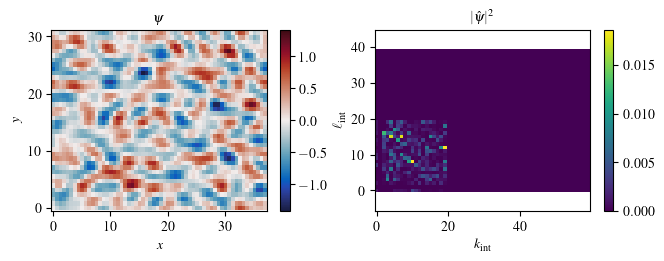

In [99]:
fig=plt.figure(figsize=(13/1.7, 4/1.7))
plt.subplot(1, 2, 1)
plt.pcolormesh(x,y,psi['g'].T, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.axis('equal')
cbar = plt.colorbar();
plt.title(r"$\psi$")
plt.xlabel("$x$"); plt.ylabel("$y$")

plt.subplot(1, 2, 2)
plt.pcolormesh(k_int,l_int,psi_mag2d.T)
plt.axis('equal')
cbar = plt.colorbar();
plt.title(r'$|\hat{\psi}|^2$')
plt.xlabel(r"$k_\mathrm{int}$"); plt.ylabel(r"$\ell_\mathrm{int}$")

plt.show()

2D real fields also requires factors to match the Parseval's theorem, and it is slightly more complicated. The factor should be $1/4$; except when $k=0$ xor $\ell=0$, it should be $1/2$; and when $k=0$ and $\ell=0$, it should be one. 

In [100]:
factor = np.ones(psi_mag2d.shape)*1/4
factor[0,:] *= 2; factor[:,0] *= 2

In [101]:
print(np.sum(psi_mag2d*factor))
print(d3.Integrate(np.abs(psi)**2,('x','y')).evaluate()['g'].ravel()[0]/(Lx*Ly))

0.16622768166042284
0.1662276816604228


For isotropic 2D fields, the isotropic power density spectrum is a convenient measurememt of the amount of variance in each length scale. It is a 1D function of $K = \sqrt{k^2+\ell^2}$, the magnitude of the wavenumber. It is easy to see that the isotropic spectrum ignored the difference between different $(k,\ell)$ values with the same magnitude.

To convert the 2D spectrum to the isotropic spectrum, we need to sum over coefficients with similar wavenumber magnitude. It is important here to make sure no mode is double counted and no mode is left behind. This ensures the isotropic spectrum preserve variance. 

We build two version, one for when the field has $Lx=Ly$ and isotropic discretization. This is the most common situation. We also allows for anisotropic discretizated inputs.

In [102]:
def isospectrum_2d(psi_mag, k=False, l=False):
# Input of k, l is not neede for isotropic discretizated fields
    if type(k) is bool:
        N = psi_mag.shape[0]
        k_mat, l_mat = np.meshgrid(range(N), range(N))
        spec_k_ary = np.arange(0,int(N/2)) # the K array where the spectrum will be indexed by
    else:
        k=k.ravel(); l=l.ravel()
        k_min = np.min([k[-1],l[-1]])
        k_mat, l_mat = np.meshgrid(k, l)
        dk = k[2]-k[1]; dl = l[2]-l[1]; dkmax = np.max([dk,dl])
        spec_k_ary = np.arange(0,k_min,dkmax)
    #####  
    psi_spec = np.zeros(spec_k_ary.size)
    for i in range(spec_k_ary.size):
        # make the mask for each K
        mask = np.sqrt(k_mat**2+l_mat**2) < spec_k_ary[i]
        mask *= np.sqrt(k_mat**2+l_mat**2) >= spec_k_ary[i-1]
        mask = mask*1/4; mask[0,:] *= 2; mask[:,0] *= 2;

        psi_spec[i] = (mask*psi_mag.T).sum()

    return psi_spec

In [103]:
psi_spec = isospectrum_2d(psi_mag2d,k,l)

In [104]:
print(np.sum(psi_spec))
print(d3.Integrate(np.abs(psi)**2,('x','y')).evaluate()['g'].ravel()[0]/(Lx*Ly))

0.16622768166042284
0.1662276816604228


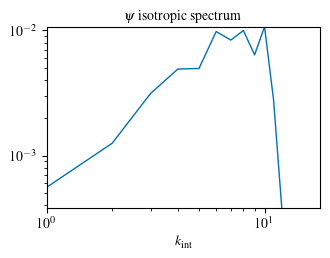

In [94]:
fig=plt.figure(figsize=(6/1.7, 4/1.7))

plt.loglog(psi_spec)
plt.title(r'$\psi$ isotropic spectrum')
plt.xlabel(r"$k_\mathrm{int}$")

plt.show()

Everything checks out. 

We wrap up out function for 1D and 2D into into one function that one can just call [`isospectrum.py`](https://github.com/Empyreal092/GFD_in_Dedalus_book/isospectrum/isospectrum.py). 

The work is not done. The above code is not tested for complex flieds. It is also not tested for higher dimensional fields. I encourage you to contribute if you are interested!